In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import min-max scaling function
from sklearn.preprocessing import MinMaxScaler

# Import keras lstm model
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional, GRU, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing.sequence import TimeseriesGenerator

# Metrics
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import time

C:\Users\mimam\AppData\Local\Temp\ipykernel_6500\1048350913.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
data = pd.read_csv('./store5.csv')
data

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico
0,1452,2013-01-01,5,AUTOMOTIVE,0.000,0,NaN
1,1453,2013-01-01,5,BABY CARE,0.000,0,NaN
2,1454,2013-01-01,5,BEAUTY,0.000,0,NaN
3,1455,2013-01-01,5,BEVERAGES,0.000,0,NaN
4,1456,2013-01-01,5,BOOKS,0.000,0,NaN
...,...,...,...,...,...,...,...
55567,3000586,2017-08-15,5,POULTRY,241.011,1,47.57
55568,3000587,2017-08-15,5,PREPARED FOODS,52.121,0,47.57
55569,3000588,2017-08-15,5,PRODUCE,1357.823,4,47.57
55570,3000589,2017-08-15,5,SCHOOL AND OFFICE SUPPLIES,0.000,0,47.57


In [3]:
data['dcoilwtico'] = data['dcoilwtico'].ffill()
data['dcoilwtico'] = data['dcoilwtico'].bfill()
data['dcoilwtico'].isnull().sum()

0

In [4]:
eggs = data.loc[data['family'] == 'EGGS']
eggs = eggs.drop(columns = ['id', 'store_nbr', 'family'])
eggs['date'] = pd.to_datetime(eggs['date'])
eggs = eggs.set_index('date')
eggs

,sales,onpromotion,dcoilwtico
date,,,
2013-01-01,0.0,0,93.14
2013-01-02,246.0,0,93.14
2013-01-03,120.0,0,92.97
2013-01-04,141.0,0,93.12
2013-01-05,143.0,0,93.12
...,...,...,...
2017-08-11,95.0,24,48.81
2017-08-12,77.0,0,48.81
2017-08-13,100.0,0,48.81


In [5]:
eggs['year'] = eggs.index.year
eggs['month'] = eggs.index.month
eggs['week'] = eggs.index.isocalendar().week
eggs['day'] = eggs.index.day
eggs['day of the week'] = eggs.index.weekday
eggs

,sales,onpromotion,dcoilwtico,year,month,week,day,day of the week
date,,,,,,,,
2013-01-01,0.0,0,93.14,2013,1,1,1,1
2013-01-02,246.0,0,93.14,2013,1,1,2,2
2013-01-03,120.0,0,92.97,2013,1,1,3,3
2013-01-04,141.0,0,93.12,2013,1,1,4,4
2013-01-05,143.0,0,93.12,2013,1,1,5,5
...,...,...,...,...,...,...,...,...
2017-08-11,95.0,24,48.81,2017,8,32,11,4
2017-08-12,77.0,0,48.81,2017,8,32,12,5
2017-08-13,100.0,0,48.81,2017,8,32,13,6


In [6]:
from sklearn.preprocessing import LabelEncoder

# Contoh data tahun
tahun = [2013, 2014, 2015, 2016, 2017]

# Inisialisasi dan fitting LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(eggs['year'])

# Transformasi data tahun
eggs['year'] = label_encoder.transform(eggs['year']) + 1
eggs['week'] = eggs['week'].astype(int)
eggs.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1684 entries, 2013-01-01 to 2017-08-15
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   sales            1684 non-null   float64
 1   onpromotion      1684 non-null   int64  
 2   dcoilwtico       1684 non-null   float64
 3   year             1684 non-null   int64  
 4   month            1684 non-null   int32  
 5   week             1684 non-null   int32  
 6   day              1684 non-null   int32  
 7   day of the week  1684 non-null   int32  
dtypes: float64(2), int32(4), int64(2)
memory usage: 92.1 KB


# LSTM

In [7]:
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
x = eggs[['dcoilwtico', 'onpromotion']].copy()
y = eggs['sales'].copy()

x['dcoilwtico'] = x_scaler.fit_transform(x['dcoilwtico'].values.reshape(-1, 1))
y = y_scaler.fit_transform(y.values.reshape(-1, 1))

In [8]:
def load_data(X, seq_len, test_size=30):
    amount_of_features = X.shape[1]
    X_mat = X.values
    sequence_length = seq_len + 1
    data = []
    
    for index in range(len(X_mat) - sequence_length):
        data.append(X_mat[index: index + sequence_length])
    
    data = np.array(data)
    train_data = data[:-test_size]  # Exclude last 'test_size' data points for test set
    
    x_train = train_data[:, :-1]
    y_train = train_data[:, -1][:,-1]
    
    x_test = data[-test_size:, :-1] 
    y_test = data[-test_size:, -1][:,-1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    return x_train, y_train, x_test, y_test

window = 7
x['sales'] = y
X_train, y_train, X_test, y_test = load_data(x, window,test_size=30)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1646, 7, 3) (1646,) (30, 7, 3) (30,)


In [9]:
#LSTM architecture
modelLSTM = Sequential()

# First LSTM layer with Dropout regularisation
modelLSTM.add(LSTM(units=15, input_shape=(window,3)))
modelLSTM.add(Dense(units=1, kernel_initializer='uniform', activation='linear'))

# Compiling the RNN
modelLSTM.compile(optimizer='adam',loss='mse')
# Fitting to the training set
start = time.time()
history1=modelLSTM.fit(X_train,y_train,epochs=100,batch_size=10, validation_split=0.05, verbose=1)
print ('compilation time : ', time.time() - start)



Epoch 1/100

157/157 [==============================] - 4s 9ms/step - loss: 0.0560 - val_loss: 0.0081
Epoch 2/100
157/157 [==============================] - 1s 5ms/step - loss: 0.0110 - val_loss: 0.0064
Epoch 3/100
157/157 [==============================] - 1s 5ms/step - loss: 0.0102 - val_loss: 0.0071
Epoch 4/100
157/157 [==============================] - 1s 4ms/step - loss: 0.0098 - val_loss: 0.0076
Epoch 5/100
157/157 [==============================] - 1s 4ms/step - loss: 0.0097 - val_loss: 0.0055
Epoch 6/100
157/157 [==============================] - 1s 5ms/step - loss: 0.0092 - val_loss: 0.0065
Epoch 7/100
157/157 [==============================] - 1s 5ms/step - loss: 0.0090 - val_loss: 0.0054
Epoch 8/100
157/157 [==============================] - 1s 4ms/step - loss: 0.0088 - val_loss: 0.0055
Epoch 9/100
157/157 [==============================] - 1s 4ms/step - loss: 0.0087 - val_loss: 0.0052
Epoch 10/100
157/157 [==============================] - 1s 4ms/step - loss: 0.0085 - val

In [10]:
trainPredict = modelLSTM.predict(X_train)
testPredict = modelLSTM.predict(X_test)

trainPredict = y_scaler.inverse_transform(trainPredict)
trainY = y_scaler.inverse_transform([y_train])
testPredict = y_scaler.inverse_transform(testPredict)
testY = y_scaler.inverse_transform([y_test])

plot_predicted = testPredict.copy()
plot_predicted = plot_predicted.reshape(30, 1)

plot_actual = testY.copy()
plot_actual = plot_actual.reshape(30, 1)

print(plot_actual.shape)
print(plot_predicted.shape)

1/1 [==============================] - 0s 32ms/step
(30, 1)
(30, 1)


In [11]:
plot_predicted.shape

(30, 1)

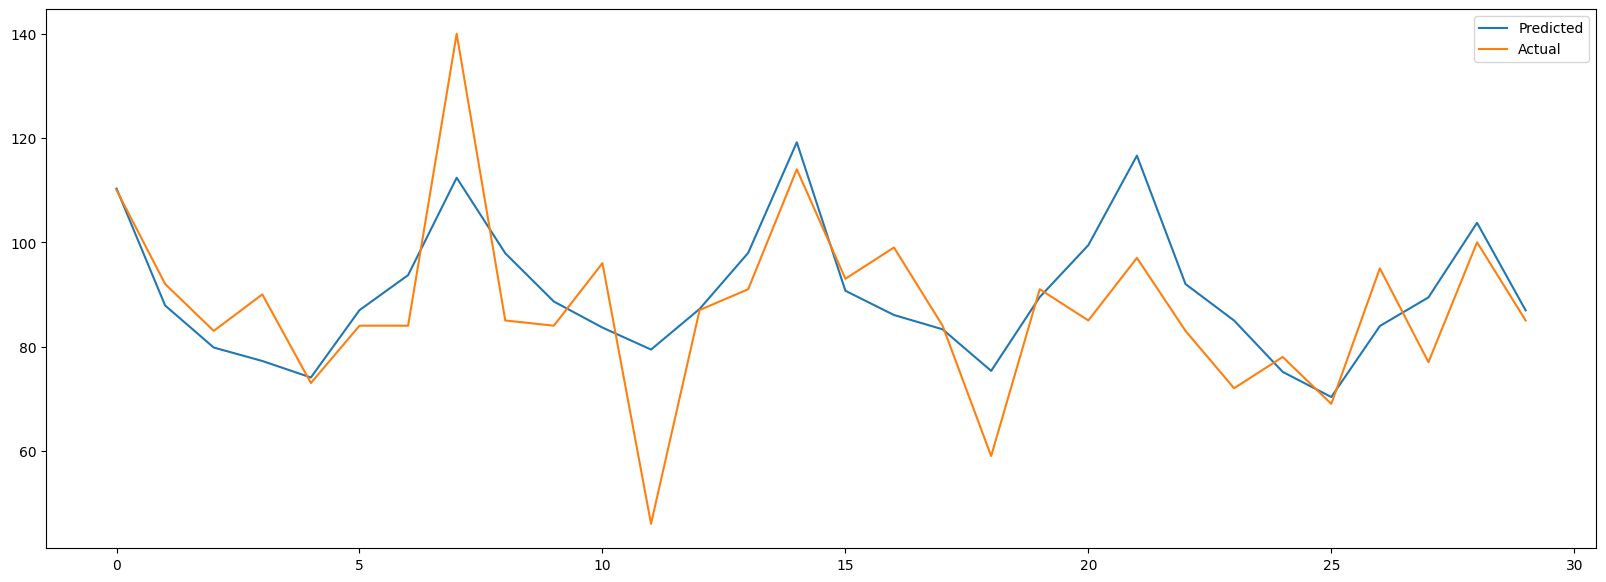

In [12]:
plt.figure(figsize=(20,7))
plt.plot(pd.DataFrame(plot_predicted), label='Predicted')
plt.plot(pd.DataFrame(plot_actual), label='Actual')
plt.legend(loc='best')
plt.show()

In [13]:
test = eggs[-30:]
# Input into pandas dataframe, test as index and plot_predicted as the column
# Reshape the data plot_predicted
plot_predicted = plot_predicted.reshape(30,)
plot_actual = plot_actual.reshape(30,)

forecastLSTM = pd.DataFrame({'test': plot_actual, 'forecast': plot_predicted}, index=test.index)
forecastLSTM

,test,forecast
date,,
2017-07-17,110.0,110.290840
2017-07-18,92.0,87.873451
2017-07-19,83.0,79.810059
2017-07-20,90.0,77.230064
2017-07-21,73.0,74.064041
2017-07-22,84.0,86.981781
2017-07-23,84.0,93.700142
2017-07-24,140.0,112.382019
2017-07-25,85.0,97.896111


# STACKED LSTM

In [14]:
#LSTM architecture
model2 = Sequential()
# First LSTM layer with Dropout regularisation
model2.add(LSTM(units=15, input_shape=(window,3),return_sequences=True))

# Second LSTM layer
model2.add(LSTM(units=15))

# The output layer
model2.add(Dense(units=1, kernel_initializer='uniform', activation='tanh'))
model2.add(Dense(units=1, kernel_initializer='uniform', activation='linear'))

earlystop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
callbacks_list = [earlystop]

# Compiling the RNN
model2.compile(optimizer='adam',loss='mean_squared_error')
# Fitting to the training set
start = time.time()
history2=model2.fit(X_train,y_train,epochs=100,batch_size=10, validation_split=0.05, verbose=1,callbacks=callbacks_list)
print ('compilation time : ', time.time() - start)

Epoch 1/100
157/157 [==============================] - 8s 17ms/step - loss: 0.0973 - val_loss: 0.0078
Epoch 2/100
157/157 [==============================] - 1s 8ms/step - loss: 0.0202 - val_loss: 0.0127
Epoch 3/100
157/157 [==============================] - 1s 9ms/step - loss: 0.0167 - val_loss: 0.0148
Epoch 4/100
157/157 [==============================] - 1s 8ms/step - loss: 0.0166 - val_loss: 0.0154
Epoch 5/100
157/157 [==============================] - 1s 8ms/step - loss: 0.0167 - val_loss: 0.0156
Epoch 6/100
157/157 [==============================] - 1s 8ms/step - loss: 0.0167 - val_loss: 0.0148
Epoch 7/100
157/157 [==============================] - 1s 9ms/step - loss: 0.0167 - val_loss: 0.0152
Epoch 8/100
157/157 [==============================] - 1s 8ms/step - loss: 0.0167 - val_loss: 0.0157
Epoch 9/100
157/157 [==============================] - 1s 8ms/step - loss: 0.0166 - val_loss: 0.0144
Epoch 10/100
157/157 [==============================] - 1s 7ms/step - loss: 0.0162 - val_l

In [15]:
trainPredict = model2.predict(X_train)
testPredict = model2.predict(X_test)

trainPredict = y_scaler.inverse_transform(trainPredict)
trainY = y_scaler.inverse_transform([y_train])
testPredict = y_scaler.inverse_transform(testPredict)
testY = y_scaler.inverse_transform([y_test])

plot_predicted = testPredict.copy()
plot_predicted = plot_predicted.reshape(30, 1)
plot_actual = testY.copy()
plot_actual = plot_actual.reshape(30, 1)
print(plot_actual.shape)
print(plot_predicted.shape)

1/1 [==============================] - 0s 50ms/step
(30, 1)
(30, 1)


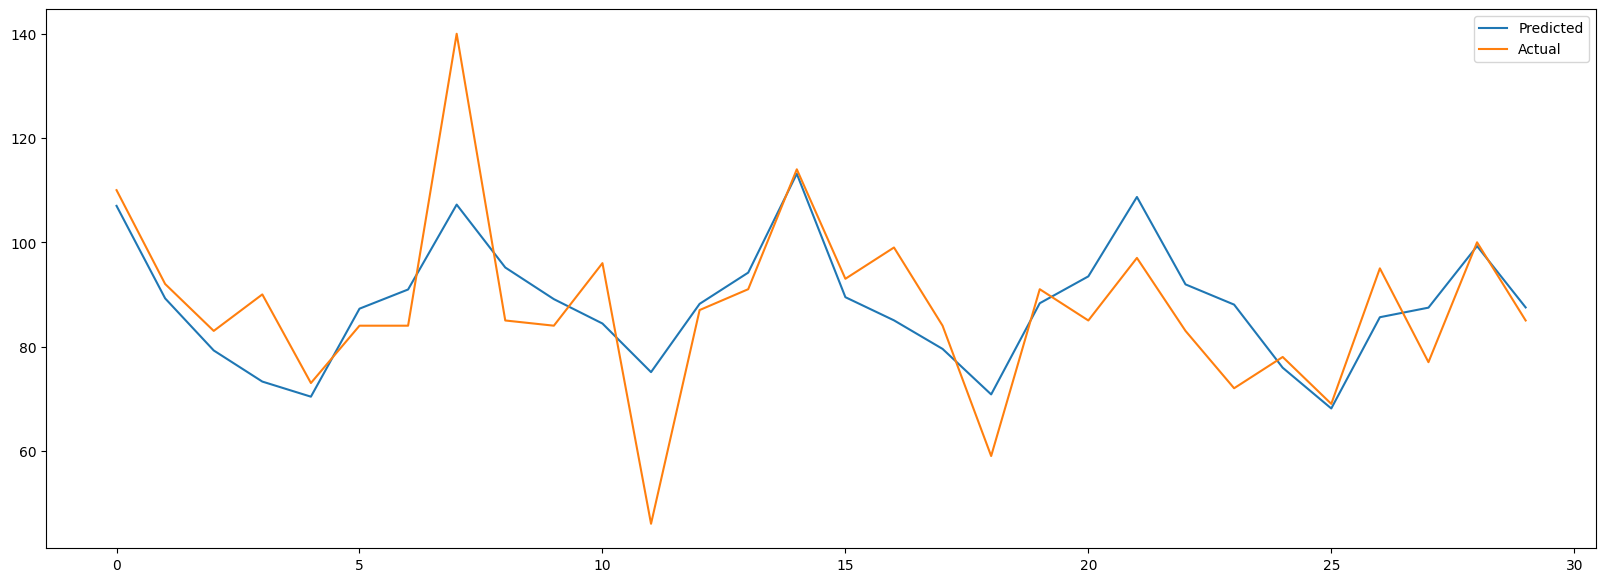

In [16]:
plt.figure(figsize=(20,7))
plt.plot(pd.DataFrame(plot_predicted), label='Predicted')
plt.plot(pd.DataFrame(plot_actual), label='Actual')
plt.legend(loc='best')
plt.show()

In [17]:
plot_predicted = plot_predicted.reshape(30,)
plot_actual = plot_actual.reshape(30,)

forecastSLSTM = pd.DataFrame({'test': plot_actual, 'forecast': plot_predicted}, index=test.index)
forecastSLSTM

,test,forecast
date,,
2017-07-17,110.0,106.986450
2017-07-18,92.0,89.237267
2017-07-19,83.0,79.249763
2017-07-20,90.0,73.278664
2017-07-21,73.0,70.381920
2017-07-22,84.0,87.264122
2017-07-23,84.0,90.943497
2017-07-24,140.0,107.229897
2017-07-25,85.0,95.164604


# BILSTM

In [18]:
# Stack LSTM architecture
model3 = Sequential()
# Bidirectional LSTM
model3.add(Bidirectional(LSTM(units=15), input_shape=(window,3)))

# The output layer
model3.add(Dense(units=1, kernel_initializer='uniform', activation='tanh'))
model3.add(Dense(units=1, kernel_initializer='uniform', activation='linear'))

earlystop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
callbacks_list = [earlystop]

# Compiling the RNN
model3.compile(optimizer='adam',loss='mean_squared_error')
# Fitting to the training set
start = time.time()
history3=model3.fit(X_train,y_train,epochs=100,batch_size=10, validation_split=0.05, verbose=1,callbacks=callbacks_list)
print ('compilation time : ', time.time() - start)

Epoch 1/100
157/157 [==============================] - 9s 18ms/step - loss: 0.0883 - val_loss: 0.0072
Epoch 2/100
157/157 [==============================] - 1s 5ms/step - loss: 0.0187 - val_loss: 0.0135
Epoch 3/100
157/157 [==============================] - 1s 5ms/step - loss: 0.0165 - val_loss: 0.0151
Epoch 4/100
157/157 [==============================] - 1s 5ms/step - loss: 0.0145 - val_loss: 0.0067
Epoch 5/100
157/157 [==============================] - 1s 5ms/step - loss: 0.0110 - val_loss: 0.0075
Epoch 6/100
157/157 [==============================] - 1s 5ms/step - loss: 0.0102 - val_loss: 0.0061
Epoch 7/100
157/157 [==============================] - 1s 5ms/step - loss: 0.0099 - val_loss: 0.0054
Epoch 8/100
157/157 [==============================] - 1s 5ms/step - loss: 0.0097 - val_loss: 0.0052
Epoch 9/100
157/157 [==============================] - 1s 5ms/step - loss: 0.0096 - val_loss: 0.0049
Epoch 10/100
157/157 [==============================] - 1s 5ms/step - loss: 0.0095 - val_l

In [19]:
trainPredict = model3.predict(X_train)
testPredict = model3.predict(X_test)

trainPredict = y_scaler.inverse_transform(trainPredict)
trainY = y_scaler.inverse_transform([y_train])
testPredict = y_scaler.inverse_transform(testPredict)
testY = y_scaler.inverse_transform([y_test])

plot_predicted = testPredict.copy()
plot_predicted = plot_predicted.reshape(30, 1)
plot_actual = testY.copy()
plot_actual = plot_actual.reshape(30, 1)
print(plot_actual.shape)
print(plot_predicted.shape)

1/1 [==============================] - 0s 42ms/step
(30, 1)
(30, 1)


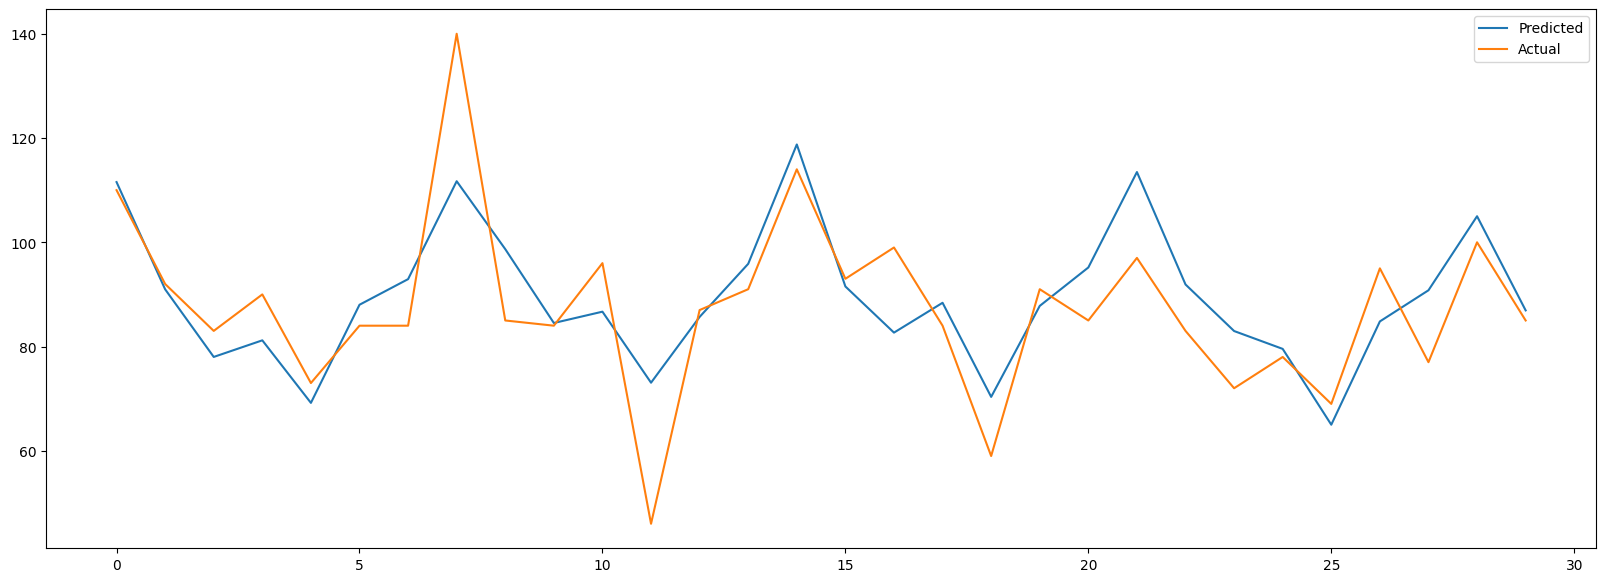

In [20]:
plt.figure(figsize=(20,7))
plt.plot(pd.DataFrame(plot_predicted), label='Predicted')
plt.plot(pd.DataFrame(plot_actual), label='Actual')
plt.legend(loc='best')
plt.show()

In [21]:
plot_predicted = plot_predicted.reshape(30,)
plot_actual = plot_actual.reshape(30,)

forecastBILSTM = pd.DataFrame({'test': plot_actual, 'forecast': plot_predicted}, index=test.index)
forecastBILSTM

,test,forecast
date,,
2017-07-17,110.0,111.550743
2017-07-18,92.0,90.978203
2017-07-19,83.0,78.005653
2017-07-20,90.0,81.190544
2017-07-21,73.0,69.193024
2017-07-22,84.0,88.016670
2017-07-23,84.0,92.930397
2017-07-24,140.0,111.715355
2017-07-25,85.0,98.686195


In [22]:
model = [forecastLSTM, forecastSLSTM, forecastBILSTM]
model_name = ['LSTM', 'Stacked LSTM', 'BILSTM']
metrics = []

for i in range(len(model)):
    mae = mean_absolute_error(model[i]['test'], model[i]['forecast'])
    mse = mean_squared_error(model[i]['test'], model[i]['forecast'])
    r2 = r2_score(model[i]['test'], model[i]['forecast'])
    metrics.append([mae, mse, r2])
    
metrics = pd.DataFrame(metrics, columns=['MAE', 'MSE', 'R2'], index=model_name)
metrics.sort_values(by = ['R2'], ascending = False)

,MAE,MSE,R2
BILSTM,8.088737,113.795244,0.583140
Stacked LSTM,8.020152,123.365031,0.548084
LSTM,8.685808,139.348506,0.489533
